# SOM for clustering 

Apply SOM to the time averaged dataset.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
import glasbey

In [2]:
# 3d plot
from mpl_toolkits.basemap import Basemap
import matplotlib

def coupled_label_plot(df):
    mymap = Basemap(llcrnrlon=df["LONGITUDE"].min(), llcrnrlat=df["LATITUDE"].min(), urcrnrlon=df["LONGITUDE"].max(), urcrnrlat=df["LATITUDE"].max(), fix_aspect=False)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df["LONGITUDE"], df["LATITUDE"], df["LEV_M"], c=df["color"], s=0.5, alpha=1, zorder=4)  # df["predictions"]
    ax.add_collection3d(mymap.drawcoastlines(linewidth=0.5))
    ax.set_box_aspect((np.ptp(df["LONGITUDE"]), np.ptp(df["LATITUDE"]), np.ptp(df["LEV_M"])/50))  # aspect ratio is 1:1:1 in data space
    plt.gca().invert_zaxis()
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(df["e0"], df["e1"], df["e2"], c=df["color"], alpha=0.8, zorder=4, s=1)  # , s=s, alpha=1, zorder=4)
    plt.show(block=True)

## Load data

In [7]:
df = pd.read_csv("../ocean_cluster_validation/data/df_wide_knn.csv")

In [8]:
df

,LEV_M,LATITUDE,LONGITUDE,P_TEMPERATURE,P_SALINITY,P_OXYGEN,P_NITRATE,P_SILICATE,P_PHOSPHATE
0,0.0,0.5,-50.5,28.460455,21.498941,170.857143,11.572727,155.681818,1.096636
1,0.0,0.5,-49.5,28.522286,0.049500,207.685714,13.100000,159.371429,1.765000
2,0.0,0.5,-48.5,27.913600,21.889140,175.795652,4.944400,53.952400,1.430400
3,0.0,0.5,-47.5,27.836294,29.148302,195.915060,0.296204,2.984107,0.297895
4,0.0,0.5,-46.5,27.494646,35.559235,188.929825,0.233333,2.900000,0.161738
...,...,...,...,...,...,...,...,...,...
49126,4000.0,52.5,-17.5,2.527371,34.906663,240.803317,22.209765,44.651500,1.494253
49127,4000.0,52.5,-16.5,2.518000,34.902333,239.700000,21.953333,42.020000,1.400000
49128,4000.0,53.5,-45.5,2.150000,34.920000,291.720821,14.795568,12.313487,1.011798
49129,4000.0,53.5,-22.5,2.590000,34.901000,240.780000,22.480000,45.160000,1.513200


## Transform longitude

In [9]:
# transform longitude
df["LONGITUDE0"] = np.sin(2*np.pi*(180 + df["LONGITUDE"])/360)
df["LONGITUDE1"] = np.cos(2*np.pi*(180 + df["LONGITUDE"])/360)
df_dropped = df.drop(["LATITUDE", "LONGITUDE", "LONGITUDE0", "LONGITUDE1", "LEV_M"], axis=1)

In [10]:
df_dropped

,P_TEMPERATURE,P_SALINITY,P_OXYGEN,P_NITRATE,P_SILICATE,P_PHOSPHATE
0,28.460455,21.498941,170.857143,11.572727,155.681818,1.096636
1,28.522286,0.049500,207.685714,13.100000,159.371429,1.765000
2,27.913600,21.889140,175.795652,4.944400,53.952400,1.430400
3,27.836294,29.148302,195.915060,0.296204,2.984107,0.297895
4,27.494646,35.559235,188.929825,0.233333,2.900000,0.161738
...,...,...,...,...,...,...
49126,2.527371,34.906663,240.803317,22.209765,44.651500,1.494253
49127,2.518000,34.902333,239.700000,21.953333,42.020000,1.400000
49128,2.150000,34.920000,291.720821,14.795568,12.313487,1.011798
49129,2.590000,34.901000,240.780000,22.480000,45.160000,1.513200


## Scale data

In [11]:
# scaling
scaler = MinMaxScaler() # StandardScaler()  MinMaxScaler  RobustScaler
scaler.fit(df_dropped)
df_scaled = pd.DataFrame(scaler.transform(df_dropped), columns=df_dropped.columns)

## Correlation

In [12]:
x_corr = df_scaled.corr()

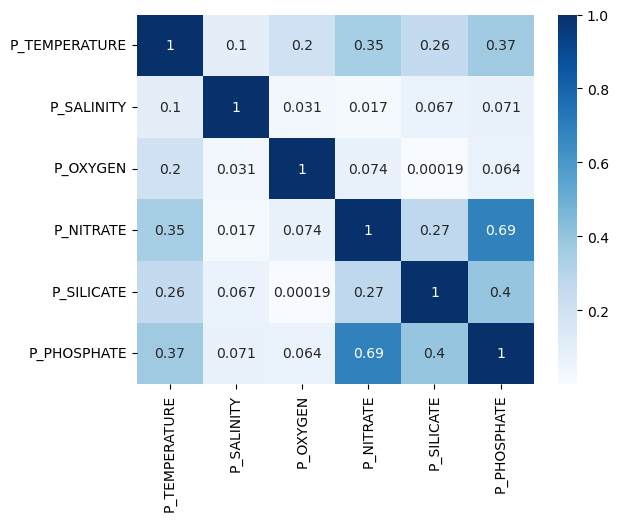

In [13]:
sns.heatmap(x_corr*x_corr, cmap="Blues", annot=True)
plt.show()

## UMAP

In [14]:
X = df_scaled.to_numpy()

In [15]:
import umap
embedding = umap.UMAP(min_dist=0.0, n_components=3, n_neighbors=20).fit_transform(X)

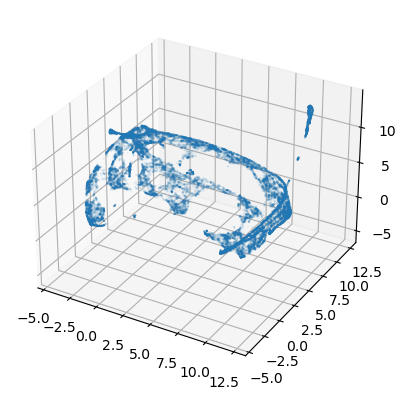

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], alpha=0.1, zorder=4, s=0.1)  # , s=s, alpha=1, zorder=4)
plt.show(block=True)

## Clustering

In [17]:
# determine mapsize
pca = PCA() 
pca_out =pca.fit_transform(embedding)
eigenvalue1 = pca.explained_variance_[0]
eigenvalue2 = pca.explained_variance_[1]
max_number_clusters = 500

ax1 = int(np.ceil(max_number_clusters*(eigenvalue1/(eigenvalue1+eigenvalue2))))
ax2 = int(np.ceil(max_number_clusters*(eigenvalue2/(eigenvalue1+eigenvalue2))))

In [18]:
import sompy

# sompy
mapsize = [ax1, ax2]  # related to proportion of eigenvectors --> take first 2 eigenvalues from PCA

som = sompy.SOMFactory.build(embedding,   # embedding df_scaled X
                             mapsize=mapsize, 
                             mask=None, 
                             mapshape='planar', 
                             lattice='hexa', 
                             normalization=None, 
                             initialization='pca', 
                             neighborhood='gaussian', 
                             training='batch', 
                             name='sompy')

som.train(n_job=1, verbose='info', 
          train_rough_len=60,  # 100
          train_rough_radiusin=3, # 5 (initial radius, how conctracted the map is initially)
          train_rough_radiusfin=1,
          train_finetune_len=150, # 300+ (epochs)
          train_finetune_radiusin=1.3,
          train_finetune_radiusfin=0.1,)  # verbose='debug' will print more, and verbose=None wont print anything

 Training...
 pca_linear_initialization took: 0.603000 seconds
 Rough training...
 radius_ini: 3.000000 , radius_final: 1.000000, trainlen: 60

 epoch: 1 ---> elapsed time:  168.956000, quantization error: 2.537601



MemoryError: Unable to allocate 25.3 GiB for an array with shape (58328, 58328) and data type float64

In [ ]:
from sompy.visualization.mapview import View2D

dim = embedding.shape[1]
col_sz = 4
view2D  = View2D(20, 4*(dim/col_sz)*.6, "codage ", text_size=10)
view2D.show(som, col_sz=col_sz, which_dim="all", denormalize=False) ;

In [ ]:
topographic_error = som.calculate_topographic_error()
quantization_error = som.calculate_quantization_error()
print ("Topographic error  = %s\nQuantization error = %s" % (topographic_error, quantization_error))

In [ ]:
# confusion matrix my cluster labels vs som cluster labels
# --> how many clusters does SOM cluster spread into

In [ ]:
# map back from embedding to geographic space
df["e0"] = embedding[:, 0]
df["e1"] = embedding[:, 1]
df["e2"] = embedding[:, 2]

In [ ]:
# bmus = som.find_bmu(df_scaled[['P_TEMPERATURE', 'P_SALINITY', 'P_OXYGEN', 'P_NITRATE', 'P_SILICATE','P_PHOSPHATE']])
# df["bmu"] = bmus[0,:]

bmus = som.find_bmu(df[["e0", "e1", "e2"]])#, njb=1, nth=1)#, metric='euclidean')
df["bmu"] = bmus[0,:]

In [ ]:
len(df["bmu"].unique())

In [ ]:
import glasbey

# define good colors for clusters
unique_labels = np.sort(np.unique(df["bmu"]))
colors = glasbey.create_palette(palette_size=len(unique_labels))
color_map = {label: color for label, color in zip(unique_labels, colors)}
df["color"] = df["bmu"].map(lambda x: color_map[x])
# df.loc[df["labels"] == -1, "color"] = "#000000"  # color noise in black
# df.drop(df[df["labels"] == -1].index, inplace=True)  # or drop noise

In [ ]:
coupled_label_plot(df)

In [ ]:
plt.rcParams["figure.figsize"] = (6, 4)
for depth in df["LEV_M"].unique():
    temp = df[df["LEV_M"] == depth]
    plt.scatter(temp["LONGITUDE"], temp["LATITUDE"], c=temp["color"], s=5, alpha=1)
    # sns.scatterplot(temp, x="LONGITUDE", y="LATITUDE", hue="predictions", s=10, palette="Set3", alpha=1)
    plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (10, 5)

df_dbscan = pd.read_csv("data/dbscan_on_embedding_60.csv")  # dbscan_on_embedding_60

df_merged = df.merge(df_dbscan[["LATITUDE", "LONGITUDE", "LEV_M", "labels"]], on=["LATITUDE", "LONGITUDE", "LEV_M"], how="left")
counts = df_merged[["bmu", "labels"]].groupby("bmu").nunique().sort_values("labels").reset_index()
counts["bmu"] = counts["bmu"].astype(str)

plt.bar(x=counts["bmu"], height=counts["labels"])
plt.show()

In [ ]:
df_merged["labels"] = df_merged["labels"].fillna(-1)
df_merged["bmu"] = df_merged["bmu"].fillna(-1)
df_merged["labels"] = df_merged["labels"].astype(int)
df_merged["bmu"] = df_merged["bmu"].astype(int)

In [ ]:
len(df_merged["bmu"].unique())

In [ ]:
len_labels = len(df_merged["labels"].unique())
len_bmus = mapsize[0] * mapsize[1]
res = np.full((len_labels, len_bmus), np.nan)

for i, label in enumerate(df_merged["labels"].unique()):
    for j, bmu in enumerate(df_merged["bmu"].unique()):
        if not np.isnan(i) and not np.isnan(j):
            res[i, j] = len(df_merged[(df_merged["labels"] == label) & (df_merged["bmu"] == bmu)])

In [ ]:
plt.rcParams["figure.figsize"] = (30, 5)
sns.heatmap(np.log(1+res))
plt.yticks(rotation=0)
plt.xlabel("SOM labels")
plt.ylabel("DBSCAN labels")
plt.title("Confusion matrix (log(1+count))")
plt.savefig("confusion_matrix.png")
plt.show()

- map not trained enough
- didnt plot heatmap --> how many individuals were put in each cluster (empty classes might have been there to prevent overfitting)
- watch evolution True! 

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView
vhts  = BmuHitsView(16, 12,"Hits Map", text_size=20)
vhts.show(som, anotate=True, onlyzeros=False, labelsize=12, logaritmic=False) 

In [ ]:
# implicit NNS


